In [23]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
from scipy.stats import mannwhitneyu
import itertools

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
df = pd.read_csv("marketing_campaign.csv")
df.head(3)

,user_id,date_served,marketing_channel,variant,language_displayed,converted
0,a1000,1/1/18,House Ads,personalization,English,True
1,a1001,1/1/18,House Ads,personalization,English,True
2,a1002,1/1/18,House Ads,personalization,English,True


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10037 non-null  object
 1   date_served         10021 non-null  object
 2   marketing_channel   10022 non-null  object
 3   variant             10037 non-null  object
 4   language_displayed  10037 non-null  object
 5   converted           10022 non-null  object
dtypes: object(6)
memory usage: 470.6+ KB


In [27]:
df.marketing_channel.unique()

array(['House Ads', 'Push', 'Facebook', 'Instagram', 'Email', nan],
      dtype=object)

In [28]:
df.variant.unique()

array(['personalization', 'control'], dtype=object)

In [29]:
df.variant.describe()

count       10037
unique          2
top       control
freq         5091
Name: variant, dtype: object

In [30]:
df[df['variant'] == 'personalization'].describe()

,user_id,date_served,marketing_channel,variant,language_displayed,converted
count,4946,4945,4946,4946,4946,4946
unique,4946,31,5,1,4,2
top,a8457,1/15/18,House Ads,personalization,English,False
freq,1,434,2181,4946,4863,4241


In [31]:
df[df['variant'] == 'control'].describe()

,user_id,date_served,marketing_channel,variant,language_displayed,converted
count,5091,5076,5076,5091,5091,5076
unique,5091,31,5,1,4,2
top,a6061,1/15/18,House Ads,control,English,False
freq,1,355,2552,5091,4930,4705


In [32]:
df['variant'].value_counts()

control            5091
personalization    4946
Name: variant, dtype: int64

In [33]:
df['converted'].value_counts()

False    8946
True     1076
Name: converted, dtype: int64

Посчитаем z-критерий "вручную"

In [39]:
z_crit_value = 1.96 # соответствует доверительному интервалу в 95%
k1 = df[df['variant']=='personalization']['converted'].sum()
n1 = df[df['variant']=='personalization'].shape[0]
k2 = df[df['variant']=='control']['converted'].sum()
n2 = df[df['variant']=='control'].shape[0]

k1, n1, k2, n2

(705, 4946, 371, 5091)

In [40]:
grouped = df.pivot_table(values='converted', index='variant', aggfunc=['sum', 'count'])
grouped

,sum,count
,converted,converted
variant,,
control,371,5076
personalization,705,4946


In [41]:
p1, p2 = k1/n1, k2/n2
p1, p2

(0.14253942579862516, 0.07287369868395208)

In [42]:
P = (p1*n1 + p2*n2) / (n1 + n2)
z = (p1 - p2) / (P * (1 - P) * (1/n1 + 1/n2))**(1/2)
z

11.278864170859038

Сравним полученное значение с критическим, выбранным ранее

In [43]:
if abs(z) > z_crit_value:
    print("We may reject the null hypothesis!")
else:
    print("We have failed to reject the null hypothesis")

We may reject the null hypothesis!


Отклоняем нулевую гипотизу

z-критерий, но уже воспользуемся возможностями библиотеки

In [44]:
from statsmodels.stats import proportion

z_score, z_pvalue = proportion.proportions_ztest(np.array([k1, k2]), 
                                                 np.array([n1, n2]))

print(f'Results are z_score={z_score:.3f} pvalue={z_pvalue:.3f}')

Results are z_score=11.279 pvalue=0.000


In [45]:
grouped

,sum,count
,converted,converted
variant,,
control,371,5076
personalization,705,4946


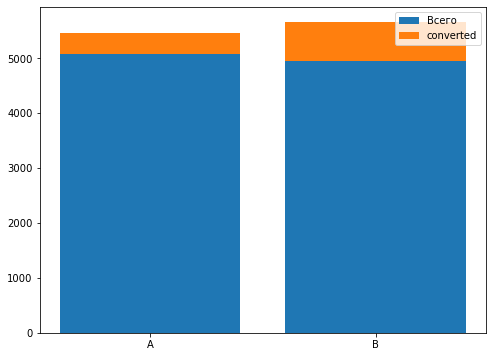

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar([1, 2], grouped['count']['converted'], label='Всего')
plt.bar([1, 2], grouped['sum']['converted'], bottom=grouped['count']['converted'], label='converted')
plt.xticks([1, 2], ['A', 'B'])
plt.legend();

Конверсия personalization больше.